<img src="https://s3-sa-east-1.amazonaws.com/preditiva.ai/diversos/preditiva_assinatura.jpg">

# Hands on: Validação de Modelos

Uma empresa do ramo alimentício tem mais de 20 mil colaboradores em todo o Brasil. Com o passar dos anos a empresa percebeu um aumento no custo do plano de saúde com seus colaboradores. Como forma de entender esse comportamento, a gerência de Benefícios e Bem Estar da Diretoria de Pessoas conduziu uma pesquisa interna com um grupo de 1.338 colaboradores sorteados aleatoriamente ao longo de um ano.

A gerência acredita que fatores como fumo e obesidade podem estar relacionados com o maior uso do plano de saúde, o que acaba elevando os custos. Portanto, os colaboradores da pesquisa responderam características pessoais como o Índice de Massa Corpórea (IMC), Qte de Filhos e se fazem uso de cigarros. Segue abaixo o dicionário dos dados:

#### Dicionário de dados

| Variável | Descrição |
| ------ | ------ |
| DtRef | Data de Referência quando a pesquisa com o colaborador foi realizada |
| Idade | Idade do colaborador |
| Sexo | Sexo do colaborador |
| IMC | Índice de Massa Corporal do colaborador |
| Qte_filhos | Qte de filhos que o colaborador tem |
| Fumante | Flag se o colaborador é fumante ou não fumante |
| Regiao | Região do Brasil onde o colaborador mora |
| Custo_Saude | Custo de Plano de Saúde que esse colaborador trouxe para a empresa 3 meses depois da Data de Referência|

Com base nessas informações, pede-se:

- **Desenvolver um modelo que estime os custos de saúde dos próximos 3 meses dos colaboradores**
- **Validar o modelo com técnicas Out of Sample, Out of Time e Validação Cruzada**
- **Qual sua conclusão a respeito do melhor tipo de validação para o problema? Qual sua estimativa para a medida de performance esperada do modelo quando for usado para prever o custo do plano de saúde?**







#### Importação das bibliotecas

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#modelo a ser treinado
from sklearn import linear_model

#métrica de performance
from sklearn.metrics import mean_squared_error, r2_score

#particionamento
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

#### Importação da base de dados

In [5]:
df = pd.read_excel('base_custos_saude.xlsx')
df

,DtRef,Idade,Sexo,IMC,Qte_Filhos,Fumante,Regiao,Custo_Saude
0,202101,25,Masculino,26.220,0,Não,Nordeste,272.132080
1,202101,23,Masculino,17.385,1,Não,Norte,277.519215
2,202101,41,Masculino,21.780,1,Não,Sudeste,627.247720
3,202101,38,Masculino,37.050,1,Não,Nordeste,607.967150
4,202101,60,Feminino,24.530,0,Não,Sudeste,1262.989670
...,...,...,...,...,...,...,...,...
1333,202112,24,Masculino,31.065,0,Sim,Nordeste,3425.405335
1334,202112,43,Masculino,25.520,5,Não,Sudeste,1447.833015
1335,202112,19,Masculino,34.900,0,Sim,Centro,3482.865400
1336,202112,45,Masculino,30.360,0,Sim,Sudeste,6259.287309


#### 1) Análise Exploratória inicial

In [6]:
df.dtypes

DtRef            int64
Idade            int64
Sexo            object
IMC            float64
Qte_Filhos       int64
Fumante         object
Regiao          object
Custo_Saude    float64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DtRef        1338 non-null   int64  
 1   Idade        1338 non-null   int64  
 2   Sexo         1338 non-null   object 
 3   IMC          1338 non-null   float64
 4   Qte_Filhos   1338 non-null   int64  
 5   Fumante      1338 non-null   object 
 6   Regiao       1338 non-null   object 
 7   Custo_Saude  1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


In [8]:
df.describe()

,DtRef,Idade,IMC,Qte_Filhos,Custo_Saude
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,202106.503737,39.207025,30.663397,1.094918,1327.042227
std,3.428562,14.049960,6.098187,1.205493,1211.001124
min,202101.000000,18.000000,15.960000,0.000000,112.187390
25%,202104.000000,27.000000,26.296250,0.000000,474.028715
50%,202106.000000,39.000000,30.400000,1.000000,938.203300
75%,202109.000000,51.000000,34.693750,2.000000,1663.991252
max,202112.000000,64.000000,53.130000,5.000000,6377.042801


In [13]:
df['DtRef'].value_counts().sort_index()

202101    105
202102    112
202103    107
202104    122
202105    114
202106    117
202107    101
202108    115
202109    119
202110    102
202111    114
202112    110
Name: DtRef, dtype: int64

In [ ]:
df['DtRef'].value_counts()

#### 2) Análise de Correlação

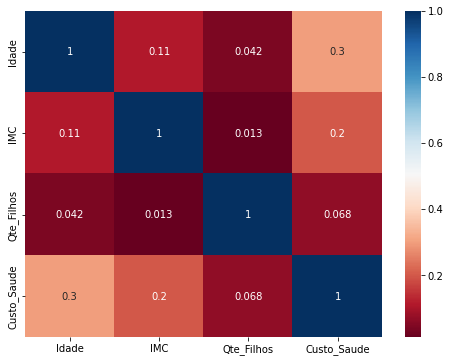

In [21]:
plt.figure(figsize=(8,6)) #ajusta o tamanho da figura
sns.heatmap(df.drop('DtRef',axis = 1).corr(), cmap='RdBu', annot=True); #troca a cor e coloca o valor da correlação dentro da matriz

Text(0.5, 1.0, 'Qte_Filhos x Custos')

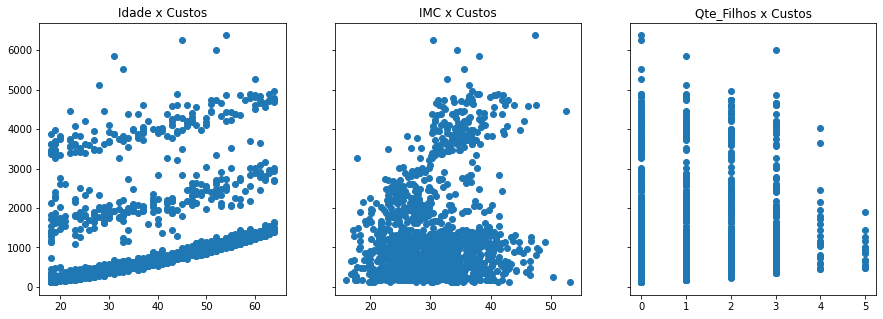

In [24]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,sharey=True,figsize=(15,5))
ax1.scatter(df['Idade'],df['Custo_Saude']);
ax1.set_title('Idade x Custos')

ax2.scatter(df['IMC'],df['Custo_Saude']);
ax2.set_title('IMC x Custos')

ax3.scatter(df['Qte_Filhos'],df['Custo_Saude']);
ax3.set_title('Qte_Filhos x Custos')

Custo de Saúde tem pouca correlação com as variáveis numéricas IMC e Qte_Filhos. Talvez as variáveis qualitativas podem ter mais influência nos Custos de Saúde. Veremos ao rodar o modelo. A variável Idade sugere uma correlação. **Fora que podem existir grupos distintos de maior custos devido ao formato da Dispersão.**

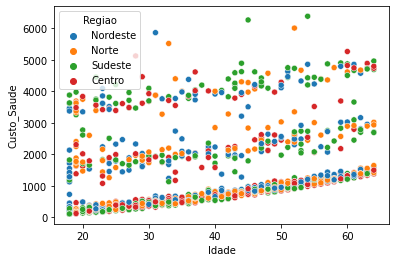

In [32]:
sns.scatterplot(df['Idade'],df['Custo_Saude'],hue = df['Regiao'] );

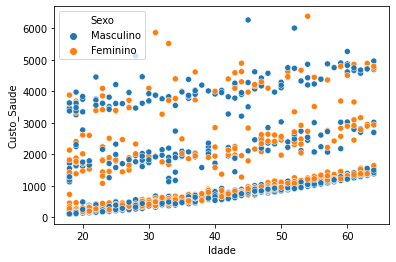

In [33]:
sns.scatterplot(df['Idade'],df['Custo_Saude'],hue = df['Sexo'] );

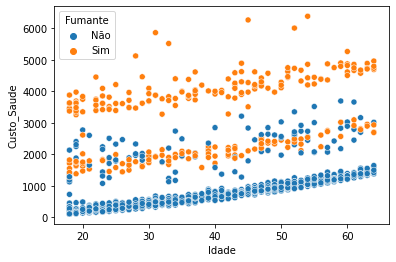

In [30]:
sns.scatterplot(df['Idade'],df['Custo_Saude'],hue = df['Fumante'] );

Parece que encontramos uma relação importante. **Fumantes tem um custo de plano de saúde muito superior em relação a quem não fuma.**

#### 3) Desenvolvimento do modelo

In [35]:
df.columns

Index(['DtRef', 'Idade', 'Sexo', 'IMC', 'Qte_Filhos', 'Fumante', 'Regiao',
       'Custo_Saude'],
      dtype='object')

In [46]:
x = df[['Idade', 'Sexo', 'IMC', 'Qte_Filhos', 'Fumante', 'Regiao']]
y = df['Custo_Saude']

In [47]:
x = pd.get_dummies(x,drop_first=True) # Como o modelo de Regressão Linear não pode ter todas as dummies, esse parâmetro remove uma delas

##### 3.1) Validação Out of Sample

In [48]:
# Particiona a base em 70% para Treino e 30% para Teste
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.30,
                                                    random_state=50)

In [49]:
modelo = linear_model.LinearRegression(fit_intercept=True)
modelo.fit(X_train,y_train)

LinearRegression()

In [65]:
pd.DataFrame({'Variáveis': X_train.columns, 'Betas': modelo.coef_})

,Variáveis,Betas
0,Idade,27.249663
1,IMC,30.491901
2,Qte_Filhos,52.617739
3,Sexo_Masculino,25.683691
4,Fumante_Sim,2422.521255
5,Regiao_Nordeste,71.411429
6,Regiao_Norte,47.779341
7,Regiao_Sudeste,10.805256


In [54]:
# R2 em Treino
custo_estimado_train = modelo.predict(X_train)
r2_train = r2_score(y_train,custo_estimado_train)

# R2 em Teste
custo_estimado_test = modelo.predict(X_test)
r2_test = r2_score(y_test,custo_estimado_test)

pd.DataFrame({'R2 em Treino':r2_train , 'R2 em Teste': r2_test},[0])

,R2 em Treino,R2 em Teste
0,0.75165,0.74665


##### 3.2) Validação Cruzada - F-Fold

In [55]:
particoes = KFold(n_splits = 5, shuffle = True, random_state = 42) 

In [59]:
r2_train = []
r2_test = []

for train_index, test_index in particoes.split(x):
    
    # Separa a base    
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #Treina o modelo
    modelo = linear_model.LinearRegression(fit_intercept=True)
    modelo.fit(X_train,y_train)
    
    # R2 em Treino
    custo_estimado_train = modelo.predict(X_train)
    r2_train.append(r2_score(y_train,custo_estimado_train))

    # R2 em Teste
    custo_estimado_test = modelo.predict(X_test)
    r2_test.append(r2_score(y_test,custo_estimado_test))
    
    
resultado = pd.DataFrame({"R2 em Treino":r2_train, "R2 em Teste":r2_test})
resultado

,R2 em Treino,R2 em Teste
0,0.752771,0.740228
1,0.750053,0.754157
2,0.757518,0.715936
3,0.743434,0.775681
4,0.753532,0.734160


In [60]:
resultado.describe().loc[['mean','std']]

,R2 em Treino,R2 em Teste
mean,0.751462,0.744032
std,0.005223,0.022392


##### 3.3) Validação Out of Time

In [13]:
df['DtRef'].value_counts().sort_index()

202101    105
202102    112
202103    107
202104    122
202105    114
202106    117
202107    101
202108    115
202109    119
202110    102
202111    114
202112    110
Name: DtRef, dtype: int64

Como temos um ano de base, vamos optar por separar 70% do ano como treino e os outros 30% como teste.

In [67]:
12*0.7

8.399999999999999

In [ ]:
# Portanto, vamos separar os meses de 202101 a 202108 como treino e o restante como teste.

In [80]:
df_dummies = pd.get_dummies(df,drop_first=True)

In [81]:
df_train = df_dummies[df_dummies['DtRef'] <= 202108].copy()
df_test = df_dummies[df_dummies['DtRef'] > 202108].copy()

In [83]:
X_train = df_train.drop(['Custo_Saude','DtRef'],axis = 1)
y_train = df_train['Custo_Saude']

X_test = df_test.drop(['Custo_Saude','DtRef'],axis = 1)
y_test = df_test['Custo_Saude']

In [84]:
modelo = linear_model.LinearRegression(fit_intercept=True)
modelo.fit(X_train,y_train)

LinearRegression()

In [85]:
pd.DataFrame({'Variáveis': X_train.columns, 'Betas': modelo.coef_})

,Variáveis,Betas
0,Idade,25.142540
1,IMC,31.804968
2,Qte_Filhos,48.894520
3,Sexo_Masculino,-34.764725
4,Fumante_Sim,2282.573503
5,Regiao_Nordeste,94.925033
6,Regiao_Norte,92.486954
7,Regiao_Sudeste,-5.951687


In [86]:
# R2 em Treino
custo_estimado_train = modelo.predict(X_train)
r2_train = r2_score(y_train,custo_estimado_train)

# R2 em Teste
custo_estimado_test = modelo.predict(X_test)
r2_test = r2_score(y_test,custo_estimado_test)

pd.DataFrame({'R2 em Treino':r2_train , 'R2 em Teste': r2_test},[0])

,R2 em Treino,R2 em Teste
0,0.730722,0.780252


##### 3.3) Validação Out of Time - Acompanhamento o R2 ao longo do tempo

In [91]:
df_dummies['Custo_Saude_Estimado'] = modelo.predict(df_dummies.drop(['Custo_Saude','DtRef'],axis = 1))

In [129]:
r2_por_ano_mes = {}

for anomes in df['DtRef'].unique():
    df_anomes = df_dummies[df_dummies['DtRef'] == anomes]
    r2 = r2_score(df_anomes['Custo_Saude'],df_anomes['Custo_Saude_Estimado'])
    r2_por_ano_mes.update( {anomes : r2} )
    
df_r2_por_ano_mes = pd.DataFrame(r2_por_ano_mes,[0]).T.rename(columns={0: 'R2'})

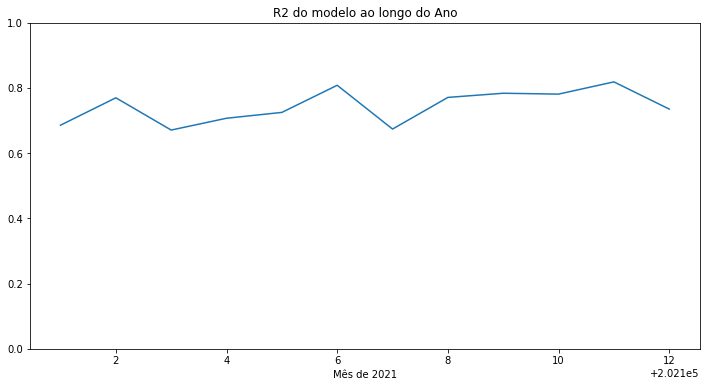

In [130]:
plt.figure(figsize=(12,6))
plt.plot(df_r2_por_ano_mes['R2'])
plt.ylim(bottom=0,top=1);

plt.title("R2 do modelo ao longo do Ano");
plt.xlabel("Mês de 2021");

In [133]:
df_r2_por_ano_mes.T

,202101,202102,202103,202104,202105,202106,202107,202108,202109,202110,202111,202112
R2,0.68562,0.76954,0.670654,0.706893,0.724774,0.807934,0.67371,0.770771,0.78354,0.780874,0.818386,0.734972


### 3.4) Afinal, qual a melhor validação para esse problema e qual o r2 geral do modelo ?

Comparando os resultados de Validação Cruzada e Validação Out of Time:

In [134]:
# Validação Cruzada k fold = 5
resultado

,R2 em Treino,R2 em Teste
0,0.752771,0.740228
1,0.750053,0.754157
2,0.757518,0.715936
3,0.743434,0.775681
4,0.753532,0.734160


In [135]:
# Validação Out of Time (treino até 202108 e teste de 202109 a 202112)
pd.DataFrame({'R2 em Treino':r2_train , 'R2 em Teste': r2_test},[0])

,R2 em Treino,R2 em Teste
0,0.730722,0.780252
